In [27]:
#Make Mega cut function
import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
from carbon_math import carbon_flux
import xesmf as xe
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xesmf as xe
from scipy.stats import linregress
import os
from funcx import cut_aco2, cut_eq_vars, proc_landschutzer, proc_landschutzer_old,cut_sst,cut_regrid_sst
#client = Client()


In [2]:
'''Preprocessing functions - Need to really describe what is going on for each of these.
Possible to combine into a general function that given something like

General_function(type=[one of bgc, physics, atmos],variable='NAME' (or array NAMES)?, Cut to Troppac? True/False, Need to regrid somehow? RegridMethod, )

Ie given a lon,lat,time,region,fixlongcoords,savepath,startyear,endyear,variablenames,trend?,


Type: BGC, Physics, Atmos
Variable = Either string or array of NAMES


Mean_of_ensemble=True #To Ensemble #0. 
Cut_eqpac= Default True (If False is global)
convert_times=True #Convert to numpy datetime.
fix_long_coords=Default False
StartDay=1982
EndDay=2019-01-01
Trend=False (Calculate per pixel trends)
Unit_fixer=False #Temporary. Maybe build this in later to automatically convert to useful units.
Regridder=False #Temporary. For the moment doesnt matter because we will regrid the other datasets to this one
plot=True #Check that it is what we think.

Tests?


Going to need a few if statements depending on which case is being handled. Start with BGC variables

Another set of questions is. How should this data be stored.

/scratch1/pit071/CAFE60/processed/*

name=Variable_Startday_TropPac_TR?_ENSMEM?
tp
'''

In [3]:
def calc_longterm_trends(ds,startday=np.datetime64('1982-01-01'),endday=np.datetime64('2020-01-01')):
    hovmol=ds
    hovmol=hovmol.where(hovmol!=-0.9999,np.nan)
    hm=hovmol.interpolate_na(dim='time').sel(time=slice(startday,endday))
    months=hm.time

    dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
    num_dates=dt_dates
    hm['time']=num_dates

    #This will calculate the per pixel trends and pvalues

    time=hm.time.values
    xx=np.concatenate(hm.T)

    tr=[]
    pv=[]
    
    
    for i in range(xx.shape[0]):
        #Add a bit of logic to mask the arrays and if they are empty just fill it with nans.
        x=xx[i,:]
        y=time

        x=np.ravel(x)
        y=np.ravel(y)
        mask=~np.isnan(x)
        x=x[mask]
        y=y[mask]
        if len(x)!=0:
            stat=linregress(y,x)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)
        else:
            #Fill that row with nans
            stat=linregress(xx[i,:],time)
            tr.append(stat.slope*365)
            pv.append(stat.pvalue)


    tr=np.array(tr).reshape(len(hm.lon),len(hm.lat)).T
    pv=np.array(pv).reshape(len(hm.lon),len(hm.lat)).T

    hh=hm.copy()
    hh=hh.drop('time')
    hh['trend']=(['lat','lon'],tr)
    hh['pval']=(['lat','lon'],pv)
    return hh

In [192]:
 def make_sst_trends_netcdf(modeldata,syear='1982-01-01'):
        ens=[]
        for i in modeldata.ensemble.values:
            print(i)
            model_tr=calc_longterm_trends(modeldata.sel(ensemble=i),syear=syear)
            ens.append(model_tr)

        model_tr=calc_longterm_trends(modeldata.mean(dim='ensemble'),syear=syear)
        ens.append(model_tr)
        trends=xr.concat(ens,dim='ensemble')
        return trends
         
def check_existing_file(spath,force=False):
    if os.path.isfile(spath)==True:
        if force==True:
            os.remove(spath)
            return False
        else:
            try:
                xr.open_dataset(spath)
                return True
            except:
                os.remove(spath)
                return False
    else:
        return False

In [195]:
def CAFE60_eqpac_cutter(modelType='BGC',
                        variable=None,
                        cut_eqpac=True,
                        save_all_data=False,
                        convert_times=True,
                        mean_of_ensemble=True,
                        fix_long_coords=True,
                        trend=False,
                        conversion=None,
                        ensemble_trends=False,
                        startday=1982,
                        endday=2020,
                        unit_fixer=False,
                        regridder=False,
                        plot=True,
                        force=False,
                        savepath='/scratch1/pit071/CAFE60/processed/'):
    '''
    A large customisable function to slice the data we want out of the CAFE60 storage.
    Focuses on Monthly data. Could be expanded to process daily but not yet.
    
    Save path  /scratch1/pit071/CAFE60/processed/*
    savename=Variable_Startday_TropPac_TR?_ENSMEM?

    modelType: BGC, Physics, Atmos
    variable = Either string or array of NAMES


    Mean_of_ensemble=True #To Ensemble #0. 
    Cut_eqpac= Default True (If False is global)
    convert_times=True #Convert to numpy datetime.
    fix_long_coords=Default False
    StartDay=1982
    EndDay=2019-01-01
    Trend=False (Calculate per pixel trends)
    Unit_fixer=False #Temporary. Maybe build this in later to automatically convert to useful units.
    Regridder=False #Temporary. For the moment do
    
    Conversion should include a modification to enact on datasets to convert to a desired format. For example *-12 for carbon to grams not moles. and then maybe * or /1000 for g/mg conversions.
    
    '''
    #Load the desired data in
    if modelType=='BGC':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr',consolidated=True)
    elif modelType=='physics':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_month.zarr',consolidated=True)
    elif modelType=='atmos':
        modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/atmos_isobaric_month.zarr',consolidated=True)
    
    #Grab the variable[s] we want.
    if type(variable)==type(None):
        print('No variable given')
        return False
    else:
        #Ok grab the variables out
        if type(variable)!=list:
            #Turn it into a list so we can iterate it
            variable=[variable]
        
        # -----
        #Ok we this function loops through here.
        for var in variable:
            print('Starting on Variable: '+var)
            try:
                #This should work with one or more variables but will need to double check this works
                modeldata=modeldata_all[var]
            except:
                print('Incorrect variable given: '+var+ '\n Should be one of:\n'+str(list(modeldata_all.keys())))
                return False
    
            # --------------------------
            #Start modifying model data
            print('Begin Dataset Size: '+str(modeldata.nbytes/1e9) + ' GB')

            modeldata=modeldata.rename({'xt_ocean':'lon','yt_ocean':'lat'})

            if fix_long_coords==True:
                modeldata['lon']=modeldata['lon']+360

            if cut_eqpac==True:
                modeldata=modeldata.sel(lon=slice(120,290),lat=slice(-20,20))
                region_name='eqpac/'
            else:
                region_name='global/'

            if convert_times==True:
                modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
                modeldata=modeldata.sel(time=slice(np.datetime64(str(startday)+'-01-01'),np.datetime64('2020-01-01')))
            else:
                print("Cut times for CF Not Implements. Try convert_times=True")

          
            if save_all_data==True:
                #Save the whole dataset here
                spath=savepath+region_name+str(var)+'_all_'+str(startday)+'.nc'
                if check_existing_file(spath,force)==False: #if it returns true then it exists and can open
                    print('Saving Dataset '+var+', size: '+str(modeldata.nbytes/1e9) + ' GB')
                    modeldata.to_netcdf(spath) 
                else:
                    print('Mean whole '+var+' Dataset already exists')

                
                
            if mean_of_ensemble==True:
                #SAVING ENS MEAN
                spath=savepath+region_name+str(var)+'_ensmean_'+str(startday)+'.nc'

                if check_existing_file(spath,force)==False: #if it returns true then it exists and can open
                    if var=='stf10':
                         modeldata_mean=modeldata.sel(ensemble=1)
                    else:
                        modeldata_mean=modeldata.mean(dim='ensemble')
                    print('Saving Mean Ens Dataset Size: '+str(modeldata_mean.nbytes/1e9) + ' GB')

                    modeldata_mean.to_netcdf(spath) 
                else:
                    print('Mean Ens Dataset already exists: '+spath)


            if trend==True:
                 #REQUIRES mean of ensemble=True
                modeldata_mean=xr.open_dataset(savepath+region_name+str(var)+'_ensmean_'+str(startday)+'.nc')[var]


                spath82=savepath+region_name+str(var)+'_meantrends_'+str(1982)+'.nc'
                spath20=savepath+region_name+str(var)+'_meantrends_'+str(2000)+'.nc'

                if check_existing_file(spath82,force)==False:
                    trend_1982=calc_longterm_trends(modeldata_mean,startday='1982-01-01')
                    trend_1982.to_netcdf(spath82)
                else:
                    print('1982 trend Dataset already exists '+spath82)

                if check_existing_file(spath20,force)==False:
                    trend_2000=calc_longterm_trends(modeldata_mean,startday='2000-01-01')
                    trend_2000.to_netcdf(spath20)
                else:
                    print('2000 trend Dataset already exists: '+spath20)


            if ensemble_trends==True:
                print('Processing individual ensemble trends. Might take a while. Probably recommend only for eqpac')
                if len(startday)==4:
                    startday=str(startday)+'-01-01'
                trends=make_sst_trends_netcdf(modeldata,startday)
                spath=savepath+region_name+str(var)+'_enstrends_'+str(startday)+'.nc'
                remove_existing_file(spath)
                trends.to_netcdf(spath)

   
    

In [140]:
def proc_landschutzer_global():
    #Load and process landschutzer data
    landschutzer_CO2=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/spco2_MPI-SOM_FFN_v2020.nc')
    landschutzer_CO2= landschutzer_CO2.assign_coords(lon=(landschutzer_CO2.lon % 360)).roll(lon=(landschutzer_CO2.dims['lon']),roll_coords=False).sortby('lon')		#EPIC 1 line fix for the dateline problem.
    #landschutzer_CO2=landschutzer_CO2.sel(lon=slice(120,290),lat=slice(-20,20)).fgco2_smoothed/365 #From per to per day
    landschutzer_CO2=landschutzer_CO2.fgco2_smoothed*12 #to grams
    landschutzer_CO2['time']=landschutzer_CO2['time'].astype('datetime64[M]')

    #Regrid
    cafe=xr.open_dataset('/scratch1/pit071/CAFE60/temp/global_outgassing.nc')
    regridder = xe.Regridder(landschutzer_CO2, cafe, 'bilinear',reuse_weights=True)
    landschutzer_CO2=regridder(landschutzer_CO2)
    landschutzer_CO2.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid.nc')
    
def cut_regrid_reynolds_sst_global():
    sst_cafe=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_ensmean_1982.nc').sst
    sst_obs=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/sst.mnmean.nc')
    
    #Apply seamask
    seamask=xr.open_dataset('/scratch1/pit071/carbon_data_ch2/seamask.nc')
    seamask= seamask.assign_coords(lon=(seamask.lon % 360)).roll(lon=(seamask.dims['lon'] // 2),roll_coords=True)
    seamask=seamask.reindex(lat=seamask.lat[::-1])

    #lat=slice(20,-20),lon=slice(120,290),
    sst_obs=sst_obs.sst.sel(time=slice('1982-01-01','2019-12-01'))
    sst_obs=sst_obs.reindex(lat=sst_obs.lat[::-1])
    regridder = xe.Regridder(sst_obs, sst_cafe, 'bilinear',reuse_weights=True)
    sst_obs_regrid=regridder(sst_obs)

    sst_obs_regrid.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.nc')

In [228]:
def cut_process_sst_obs_trends(force=False):
    sst_obs=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.nc')
    sst_obs_tr_1982=calc_longterm_trends(sst_obs.sst,'1982')
    sst_obs_tr_2000=calc_longterm_trends(sst_obs.sst,'2000')
    if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_1982.nc',force)==False:   
        sst_obs_tr_1982.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_1982.nc')
    if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_2000.nc',force)==False:
        sst_obs_tr_2000.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_2000.nc')
  
    
def process_co2_land_trends(force=False):
    land_obs=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid.nc')
    land_obs_tr_1982=calc_longterm_trends(land_obs.fgco2_smoothed/365,'1982')
    land_obs_tr_2000=calc_longterm_trends(land_obs.fgco2_smoothed/365,'2000')
    if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_1982.nc',force)==False:
        land_obs_tr_1982.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_1982.nc')
    if check_existing_file('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_2000.nc',force)==False:
        land_obs_tr_2000.to_netcdf('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_2000.nc')
    
   

In [ ]:
#starts herre

In [142]:
"""
BGC
surface_phy
pprod_gross_2d
export_prod
export_inorg
surface_dic
surface_zoo
"""
#['stf10','surface_phy']
CAFE60_eqpac_cutter(modelType='physics',
                        variable='sst',
                        cut_eqpac=False,
                        save_all_data=False,
                        trend=True,
                        force=False)

In [194]:
CAFE60_eqpac_cutter(modelType='BGC',
                        variable='stf10',
                        cut_eqpac=False,
                        save_all_data=False,
                        trend=True,
                        force=True)

Starting on Variable: stf10
Begin Dataset Size: 29.85984 GB
Saving Mean Ens Dataset Size: 0.196992 GB


<ipython-input-193-bddd17772983>:87: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  modeldata['time']=np.array(modeldata.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [138]:
proc_landschutzer_global()
cut_regrid_reynolds_sst()

In [238]:
cut_process_sst_obs_trends(True)
process_co2_land_trends(True)

In [230]:
cafe_sst_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/sst_meantrends_2000.nc')

cafe_co2_mean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('/scratch1/pit071/CAFE60/processed/global/stf10_meantrends_2000.nc')

In [231]:
land_obs=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid.nc')
land_obs_tr_1982=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_1982.nc')
land_obs_tr_2000=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzer_global_regrid_trend_1982.nc')

sst_rey_obs=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid.nc')
sst_obs_tr_1982=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_1982.nc')
sst_obs_tr_2000=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/sst.mnmean.regrid_trend_2000.nc')

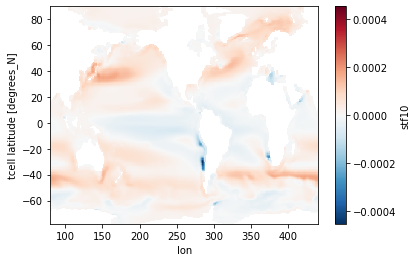

In [206]:
cafe_co2_mean.stf10.mean(dim='time').plot()

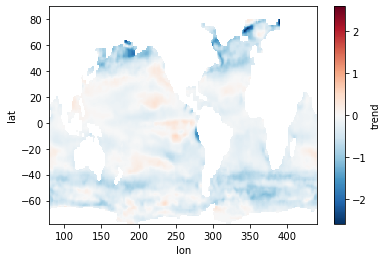

In [224]:
land_obs_tr_2000.trend.plot()

In [96]:
sst_obs /scratch1/pit071/CAFE60/processed/obs

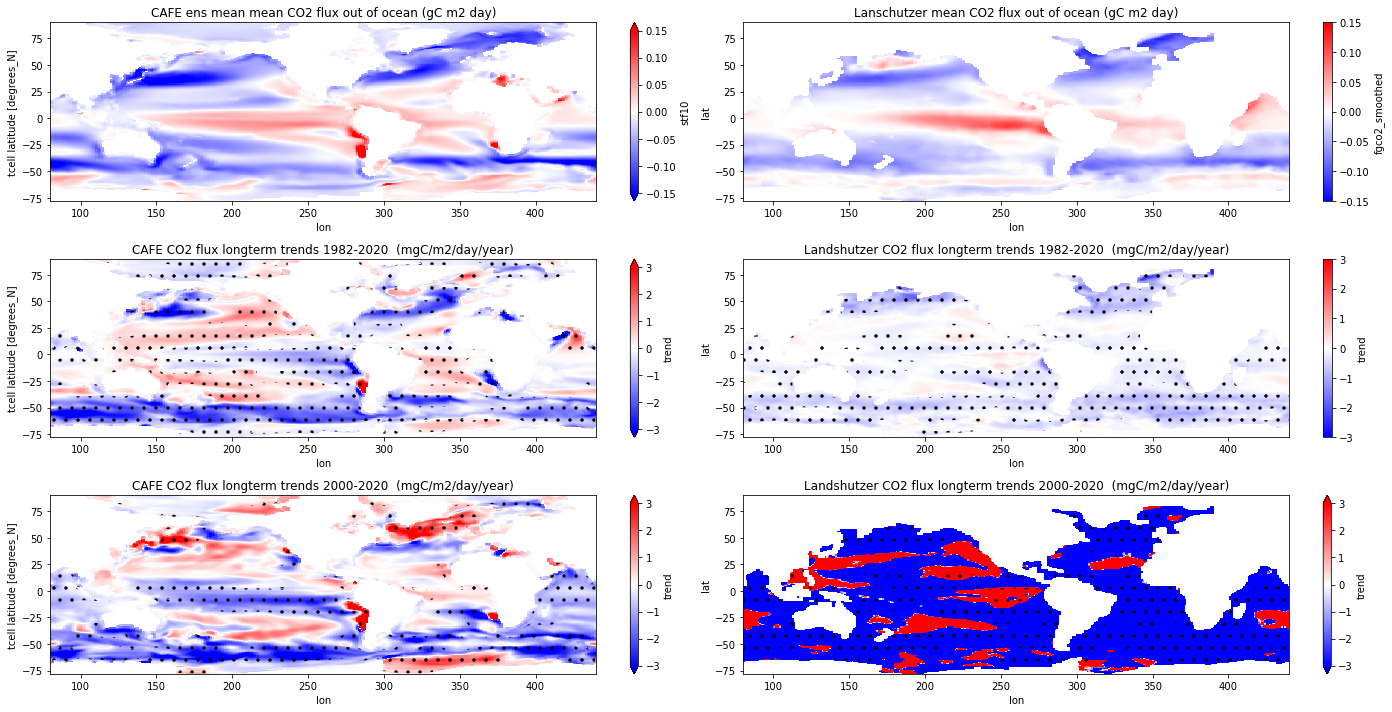

In [236]:
plt.figure(figsize=(20,10))
plt.subplot(321)

(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12).plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(322)
(land_obs.fgco2_smoothed/365).mean(dim='time').plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Lanschutzer mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(323)
((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(324)
((land_obs_tr_1982.trend)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(land_obs_tr_1982.pval.lon,land_obs_tr_1982.pval.lat,land_obs_tr_1982.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(325)
((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(326)
((land_obs_tr_2000.trend)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(land_obs_tr_2000.pval.lon,land_obs_tr_2000.pval.lat,land_obs_tr_2000.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


NameError: name 'cafe_global_tr_1982' is not defined

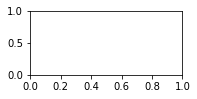

In [234]:
plt.subplot(323)
(cafe_global_tr_1982.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#(cafe_global_tr_2000.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#sst_trends.pval.plot.contourf(colors='none',hatches=['.'],levels=[0,0.001])
plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(cafe_global_tr.pval.lon,cafe_global_tr.pval.lat,cafe_global_tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(324)

(land_global_tr_1982.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#(land_global_tr_2000.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')

#sst_trends.pval.plot.contourf(colors='none',hatches=['.'],levels=[0,0.001])
plt.title('Landschutzer CO2 flux longterm trends 1982-2020 (mgC/m2/day/year)')
plt.contourf(land_global_tr.pval.lon,land_global_tr.pval.lat,land_global_tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(325)
#(cafe_global_tr_1982.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
(cafe_global_tr_2000.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#sst_trends.pval.plot.contourf(colors='none',hatches=['.'],levels=[0,0.001])
plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(cafe_global_tr.pval.lon,cafe_global_tr.pval.lat,cafe_global_tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(326)

#(land_global_tr_1982.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
(land_global_tr_2000.trend*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')

#sst_trends.pval.plot.contourf(colors='none',hatches=['.'],levels=[0,0.001])
plt.title('Landschutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(land_global_tr.pval.lon,land_global_tr.pval.lat,land_global_tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()

In [104]:
modeldata_all=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_month.zarr',consolidated=True)

['age_global',
 'cfc_11',
 'cfc_12',
 'eta_t',
 'neutral_diffusion_salt',
 'neutral_diffusion_temp',
 'neutral_gm_salt',
 'neutral_gm_temp',
 'salt',
 'salt_sponge_tend',
 'salt_vdiff_impl',
 'sst',
 'temp',
 'temp_sponge_tend',
 'temp_vdiff_impl',
 'tx_trans',
 'tx_trans_gm',
 'ty_trans',
 'ty_trans_gm',
 'u',
 'v',
 'wt']

In [49]:
#Ok lets test some of these datasets.
#surface_phy_meantrends_1982.nc
#188M	./stf10_ensmean_1982.nc
#190M	./stf10_meantrends_1982.nc
#101M	./surface_phy_meantrends_2000.nc
#18G	./stf10_all_1982.nc
#18G	./surface_phy_all_1982.nc
#188M	./surface_phy_ensmean_1982.nc
#101M	./stf10_meantrends_2000.nc

#/scratch1/pit071/CAFE60/processed/global

In [83]:
fp='/scratch1/pit071/CAFE60/processed/global/'
stf10_ensmean_1982=xr.open_dataset(fp+'stf10_ensmean_1982.nc')
stf10_mean_trends_1982=xr.open_dataset(fp+'stf10_meantrends_1982.nc')


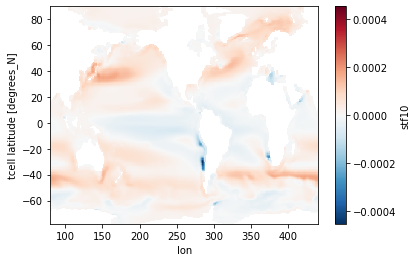

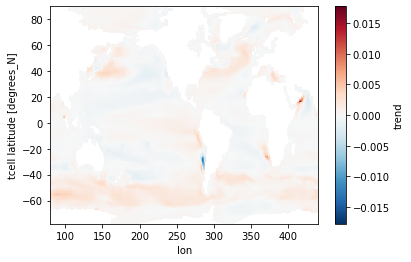

In [87]:
stf10_ensmean_1982.stf10.mean(dim='time').plot(),plt.show()
(stf10_mean_trends_1982.trend*1000).plot()

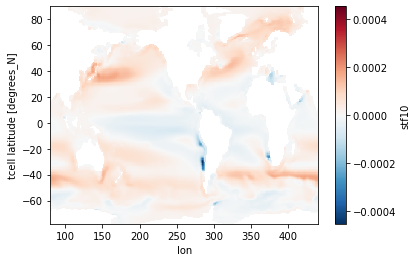

In [82]:
stf10_ensmean_1982.stf10.mean(dim='time').plot()

In [49]:
dat=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/stf10_meantrends_2000.nc')

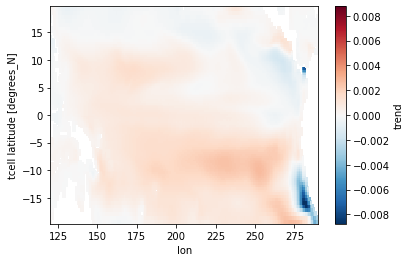

In [53]:
(dat.trend*1000).plot()

In [69]:
modeldata=xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr',consolidated=True)

In [71]:
modeldata['surface_phy']

,Array,Chunk
Bytes,29.86 GB,41.47 MB
Shape,"(720, 96, 300, 360)","(1, 96, 300, 360)"
Count,721 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [13]:

    
def cut_eq_vars():
    BGC_monthly = xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_bgc_month.zarr/',consolidated=True)
    BGC_monthly['xt_ocean']=BGC_monthly['xt_ocean']+360
    BGC_monthly=BGC_monthly.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20))
    BGC_monthly=BGC_monthly.rename({'xt_ocean':'lon','yt_ocean':'lat'})
    selected=BGC_monthly[['stf10','pprod_gross_2d','export_prod']]#,'phy']]
    
    selected['stf10']=((selected['stf10']/1000)*86400)*-12 #mmol/s to mol/day
    selected['pprod_gross_2d']=(selected['pprod_gross_2d']*6.625*12*86400)/1000
    selected['export_prod']=(selected['export_prod']*6.625*12*86400)/1000
    
    selected['time']=np.array(selected.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    selected=selected.sel(time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01')))
    
    print(str(selected.nbytes/1e9) + ' GB')
    selected.to_netcdf('/scratch1/pit071/CAFE60/eqpac_BGC.nc')

In [13]:


    
def make_sst_trends_netcdf():
    ens=[]
    for i in sst_cafe.ensemble.values:
        print(i)
        sst_cafe_tr=calc_longterm_trends(sst_cafe.sel(ensemble=i))
        ens.append(sst_cafe_tr)

    sst_cafe_tr=calc_longterm_trends(sst_cafe.mean(dim='ensemble'))
    ens.append(sst_cafe_tr)
    cafe_SST_trends=xr.concat(ens,dim='ensemble')
    cafe_SST_trends.to_netcdf('/scratch1/pit071/CAFE60/sst_trends_ens_1982.nc')

    
def cut_sst_globe():
    physics_month= xr.open_zarr('/OSM/CBR/OA_DCFP/data/model_output/CAFE/data_assimilation/d60-zarr/ocean_month.zarr',consolidated=True)
    physics_month['xt_ocean']=physics_month['xt_ocean']+360
    sst=physics_month.sst#.sel(xt_ocean=slice(120,290),yt_ocean=slice(-20,20))
    sst['time']=np.array(sst.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
    sst=sst.sel(time=slice(np.datetime64('1982-01-01'),np.datetime64('2020-01-01')))
    sst=sst.rename({'xt_ocean':'lon','yt_ocean':'lat'})
    
    print('saving Ensemble 1 SST')
    sst.sel(ensemble=1).to_netcdf('/scratch1/pit071/CAFE60/sst_globe_ens1.nc',engine='netcdf4')
    
    print('saving global SST')
    sst.to_netcdf('/scratch1/pit071/CAFE60/sst_globe.nc',engine='netcdf4')

    print('saving mean ens SST')
    sst_ens=(sst.mean(dim='ensemble'))
    sst_ens.to_netcdf('/scratch1/pit071/CAFE60/sst_globe_ensm.nc',engine='netcdf4')

def calc_trends(syear=1982):
    global_sst_trend=xr.open_dataset('/scratch1/pit071/CAFE60/sst_globe_ens1.nc').sst
    sst_cafe_tr=calc_longterm_trends(global_sst_trend,startday=np.datetime64(str(syear)+'-01-01'))
    sst_cafe_tr.to_netcdf('/scratch1/pit071/CAFE60/sst_global_trends_'+str(syear)+'.nc') #('/scratch1/pit071/CAFE60/sst_global_trends_1982.nc') or 2000
 

,Array,Chunk
Bytes,15.55 GB,1.30 MB
Shape,"(720, 50, 300, 360)","(1, 3, 300, 360)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.55 GB,1.30 MB
Shape,"(720, 50, 300, 360)","(1, 3, 300, 360)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
